## Imports and Twitter API

In [83]:
import tweepy
import sys
import jsonpickle
import json
import os
import nltk
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [ ]:
with open ("auth.txt", "r") as f:
    cred=f.readlines()
cred = [i.rstrip() for i in cred]
    
auth = tweepy.AppAuthHandler(cred[0],cred[1])

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Utility functions

In [104]:
def saveTweets(query,max_tweets):
    with open('_'.join(query)+'.json', 'w') as f:
        tweets = []
        last_id = -1
        while len(tweets) < max_tweets:
            count = max_tweets - len(tweets)
            try:
                new_tweets = api.search(q=query, count=count, max_id=str(last_id - 1),tweet_mode='extended')
                if not new_tweets:
                    break
                tweets.extend(new_tweets)
                last_id = new_tweets[-1].id
            except tweepy.TweepError as e:
                print(str(e))
                break
        for tweet in tweets:
            f.write(jsonpickle.encode(tweet._json, unpicklable=False) +'\n')
        return True

def loadTweets(query):
    with open('_'.join(query)+'.json', 'r') as f:
        data = f.readlines()
        return [json.loads(i) for i in data]

## Get tweets

In [118]:
query = ['#london','#London','london','London']

In [119]:
saveTweets(query,5000)

True

In [120]:
tweets = loadTweets(query)
len(tweets)

## Word frequencies

In [122]:
rawtext = ''.join([i['full_text'] for i in tweets]).split()
sw = nltk.corpus.stopwords.words('english')
sw.extend(['RT','&amp;'])
sw.extend(query)
text = [w for w in rawtext if w not in sw and len(w)>2]

In [124]:
dist = nltk.FreqDist(text)
top = dist.most_common(30)

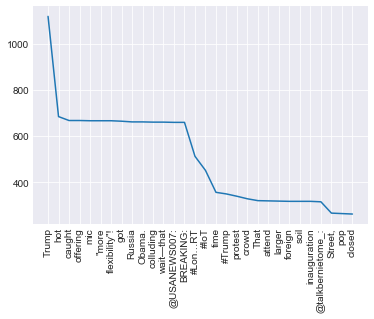

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

x = [i[0] for i in top]
y = [i[1] for i in top]

plt.plot(x, y)
plt.xticks(rotation=90);